In [1]:
import numpy as np
from random import seed, shuffle
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Set seed for reproducibility 
seed(614)
np.random.seed(614)
SIGMA = 1.5

# Kernels according to pg. 4 in lab description
def linear_kernel(x, y):
    return np.dot(x, y)

def polynomial_kernel(x, y, p):
    # Set p to an integer < 1
    return np.power((np.dot(x, y) + 1), p)

def rbf_kernel(x, y, sigma):
    # sigma controls smoothness of boundary
    return math.exp(-math.pow(np.linalg.norm(x-y),2)/ (2 * sigma * sigma))


def objective(alpha):
    kernel_trick = 0.5 * np.dot(alpha,np.dot(P,alpha)) - np.sum(alpha)
    return(kernel_trick)

def zerofun(alpha):
    # Defined as constrait 10 on pg. 4 in lab, using dot as recommended on pg. 6
    return np.dot(alpha, targets)


def indicator(x, y, lin=True):
    ind = 0
    for i in range(0, len(alpha)):
        if lin:
            ind += alpha[i] * targets[i] * linear_kernel((x,y), inputs[i])
        else:
            ind += alpha[i] * targets[i] * rbf_kernel((x, y), inputs[i], SIGMA)
    ind = ind - b
    return ind


def generate_data(linearly_sep=True):
    classA = None
    if linearly_sep:
        classA = np.concatenate((np.random.randn(10, 2) * 0.2 + [1.5, 0.5],
                                 np.random.randn(10, 2) * 0.2 + [-1.5, 0.5]))
    else:
        classA = np.concatenate((np.random.randn(10, 2) * 0.2 + [1.5, 0.5],
                                 np.random.randn(10, 2) * 0.2 + [0.5, -0.5]))
    classB = np.random.randn(20, 2) * 0.2 + [0.0 , -0.5]
    inputs = np.concatenate ((classA , classB ))
    targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))
    N = inputs.shape[0] # Number of rows (samples)
    permute = list(range(N))
    shuffle(permute)
    inputs = inputs[permute,:]
    targets = targets[permute]
    
    return classA, classB, inputs, targets, N


def main(lin=True):
    B = [(0, None) for b in range(N)]
    XC = {'type':'eq', 'fun':zerofun}
    start = np.zeros(N)
    ret = minimize(objective , start, bounds=B, constraints=XC)
    alpha = ret['x']

    support_vectors=[]
    for i in range(0, len(alpha)):
        # low limit to help in later stage classification with a C that is lower than 1.e-4
        if alpha[i] > 1.e-15 and alpha[i]< C:
            support_vectors.append((alpha[i], (inputs[i])[0], (inputs[i])[1], targets[i]))

    # b calculated using formula 7 on pg. 3, and any support vector
    b_sum = 0
    sv = support_vectors[0]
    for i in range(0, len(alpha)):
        if lin:
            b_sum += alpha[i] * targets[i] * linear_kernel((sv[1],sv[2]), inputs[i])
        else:
            b_sum += alpha[i] * targets[i] * rbf_kernel((sv[1],sv[2]), inputs[i], SIGMA)

    b = b_sum - sv[3]
    
    # So we can use indicator in plotting further down
    return alpha, b

# Slack gets a high value for now
C = float("inf")

classA, classB, inputs, targets, N = generate_data(True)
P = np.array([np.array([targets[i] * targets[j]*linear_kernel(inputs[i], inputs[j]) for i in range(N)])
             for j in range(N)])
alpha, b = main()

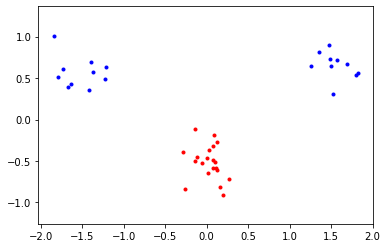

In [2]:
def plot_data(classA, classB):
    plt.plot([p[0] for p in classA],
             [p[1] for p in classA],
             'b.')
    plt.plot([p[0] for p in classB],
             [p[1] for p in classB],
             'r.')
    plt.axis('equal') # Force same scale on both axes
    plt.show() # Show the plot on the screen
plot_data(classA, classB)

The two classes plotted, showing that they should be linearly separable.

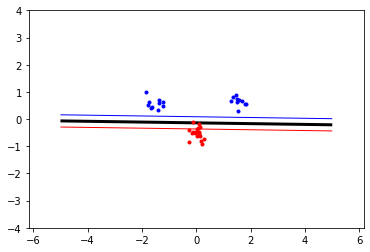

In [3]:
def plot_data_and_boundary(classA, classB, lin=True):
    plt.plot([p[0] for p in classA],
             [p[1] for p in classA],
             'b.')
    plt.plot([p[0] for p in classB],
             [p[1] for p in classB],
             'r.')
    plt.axis('equal') # Force same scale on both axes
    xgrid=np.linspace(-5, 5)
    ygrid=np.linspace(-4, 4)
    grid=np.array([[indicator(x, y, lin)
                       for x in xgrid ]
                      for y in ygrid])
    plt.contour(xgrid, ygrid, grid,
                (-1.0, 0.0, 1.0),
                colors=('red', 'black', 'blue'),
                linewidths=(1, 3, 1))
    plt.show() # Show the plot on the screen

plot_data_and_boundary(classA, classB)

The clusters are indeed linearly seperable, shown here using the linear kernel and an arbitrarily picked support vector.

### 1. Move the clusters around and change their sizes to make it easier or harder for the classifier to find a decent boundary. Pay attention to when the optimizer (minimize function) is not able to find a solution at all.

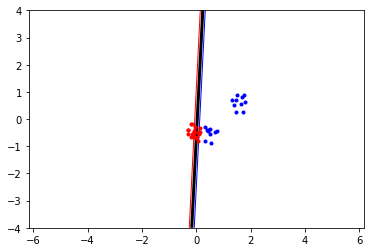

In [4]:
classA, classB, inputs, targets, N = generate_data(False)
P = np.array([np.array([targets[i] * targets[j]*linear_kernel(inputs[i], inputs[j]) for i in range(N)])
             for j in range(N)])
alpha, b = main()

plot_data_and_boundary(classA, classB)

### 2. Implement the two non-linear kernels. You should be able to classify very hard data sets with these.

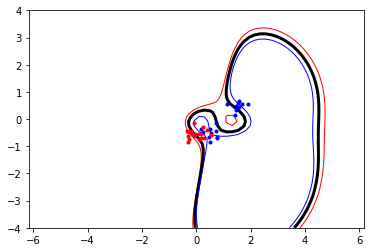

In [5]:
classA, classB, inputs, targets, N = generate_data(False)
P = np.array([np.array([targets[i] * targets[j]*rbf_kernel(inputs[i], inputs[j], SIGMA) for i in range(N)])
             for j in range(N)])
alpha, b = main(False)

plot_data_and_boundary(classA, classB, False)

This is an example of the radial basis function kernel making a better, albeit abstract, separating hyperplane than what the linear kernel did.
Similar results can be achieved using the polynomial kernel, see Appendix for those plots.

### 3. The non-linear kernels have parameters; explore how they influence the decision boundary. Reason about this in terms of the bias-variance trade-off.

With a lower sigma, the model tends to overfit, having a high variance. This can be seen in the many images below, where the model goes from almost perfectly fencing in the area of the respective datapoints, to a model that regards everything outside the red oval a blue datapoint.

SIGMA = 0.1


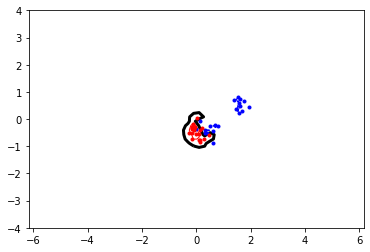

SIGMA = 0.30000000000000004


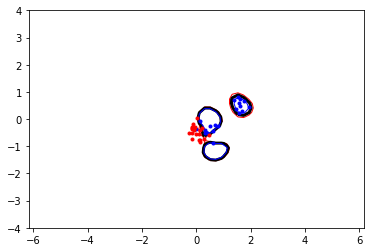

SIGMA = 0.5000000000000001


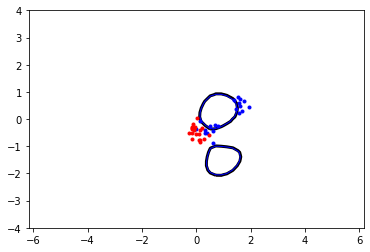

SIGMA = 0.7000000000000001


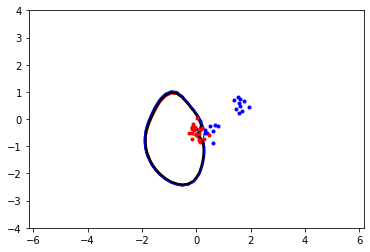

SIGMA = 0.9000000000000001


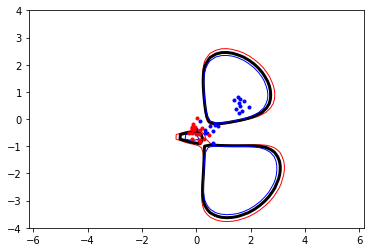

SIGMA = 1.1000000000000003


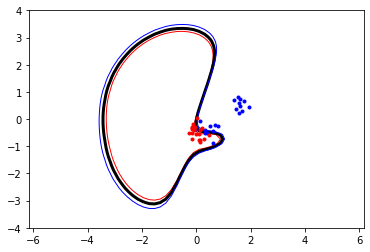

SIGMA = 1.3000000000000003


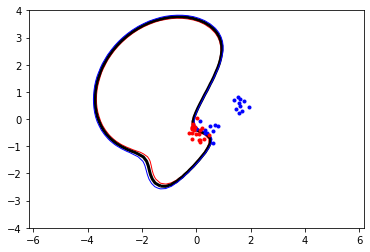

SIGMA = 1.5000000000000004


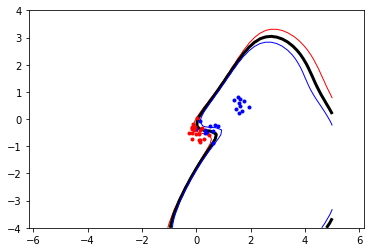

SIGMA = 1.7000000000000004


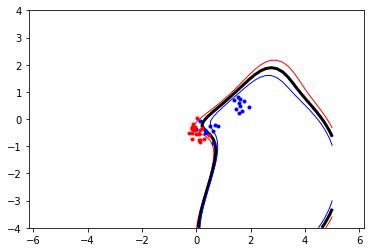

SIGMA = 1.9000000000000004


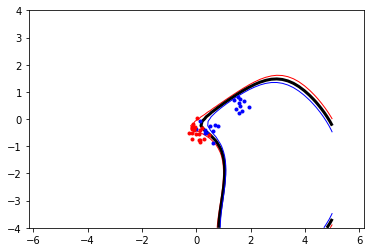

In [6]:
classA, classB, inputs, targets, N = generate_data(False)
for i in np.arange(0.1,2.0,0.2):
    SIGMA = i
    print('SIGMA = ' + str(SIGMA))
    P = np.array([np.array([targets[i] * targets[j]*rbf_kernel(inputs[i], inputs[j], SIGMA) for i in range(N)])
                 for j in range(N)])
    alpha, b = main(False)

    plot_data_and_boundary(classA, classB, False)


### 4. Explore the role of the slack parameter C. What happens for very large/small values?

C, as mentioned, is called the slack variable. For very small C's there a lot of overlap allowed, meaning that some points can be misclassified (slack is given). When C increases, less and less slack is tolerated, meaning the shapes of the separating hyperplane gets more and more convoluted.

Slack is good for ignoring noise, so for instance in the MONK-3 dataset from the last assignment. Slack can make you ignore outliers, so careful consideration has to be made when to increase or decrease slack, versus swapping out the kernel.

C = 1e-05


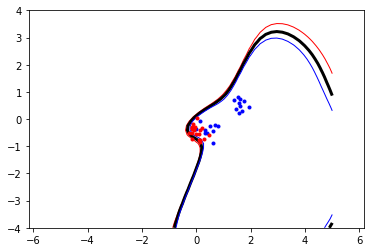

C = 0.0001


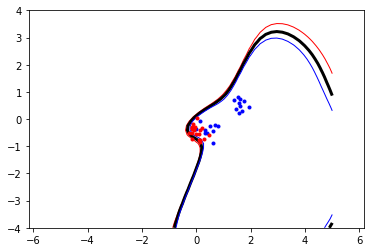

C = 0.001


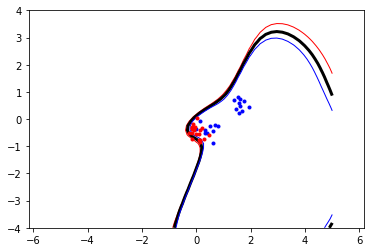

C = 0.01


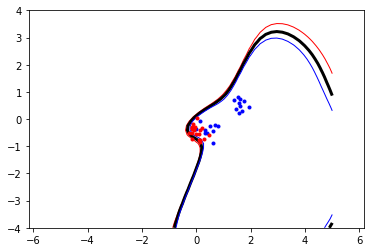

C = 0.1


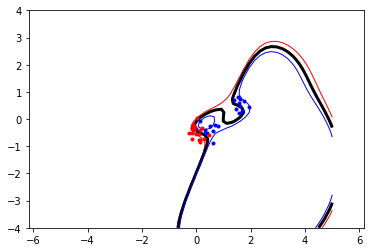

C = 1.0


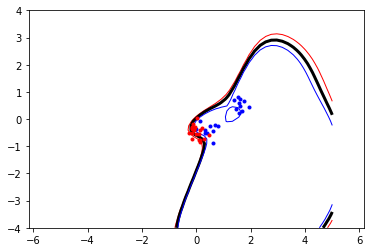

C = 10.0


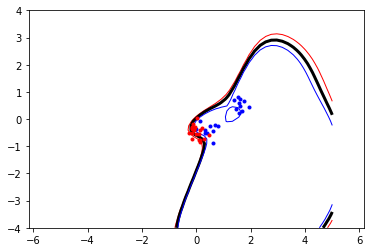

C = 100.0


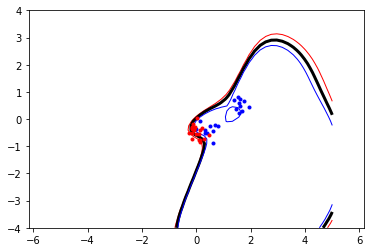

C = 1000.0


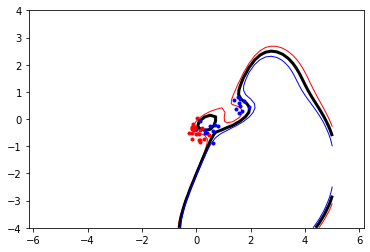

C = 10000.0


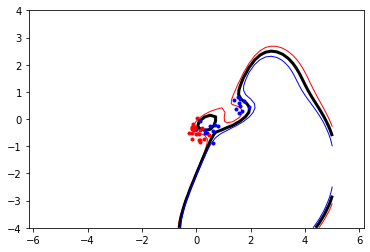

In [7]:
C = 0.00001
SIGMA = 1.5
for i in range(0,10):
    print('C = '+ str(C))
    P = np.array([np.array([targets[i] * targets[j]*rbf_kernel(inputs[i], inputs[j], SIGMA) for i in range(N)])
                 for j in range(N)])
    alpha, b = main(False)

    plot_data_and_boundary(classA, classB, False)
    C = C*10

### 5. Imagine that you are given data that is not easily separable. When should you opt for more slack rather than going for a more complex model (kernel) and vice versa?

Visualize the data, see if it makes sense to step up the model or not. Do a thorough EDA and see how many outliers there seem to be, what might cause it. If it's just noise, use more slack. If very important outliers, such as cancer cases, use more complex model. In that sense, the problem you're trying to solve matters. Don't rely on slack if the outliers are key to your model, better safe than sorry.

# Appendix: Polynomial plots

Polynomial p = 2


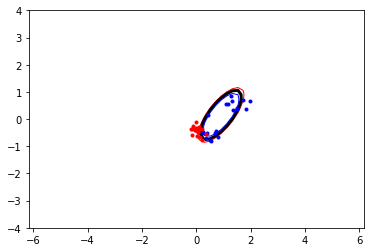

Polynomial p = 3


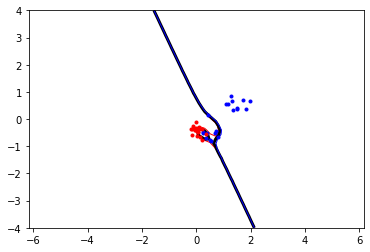

Polynomial p = 4


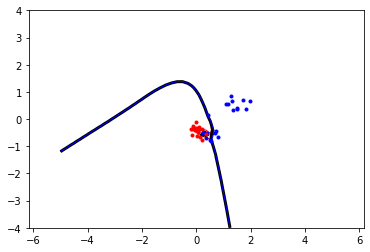

Polynomial p = 5


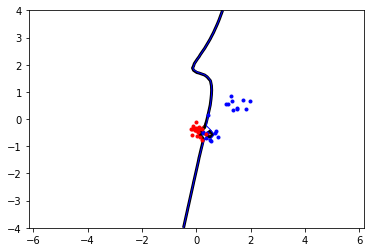

Polynomial p = 6


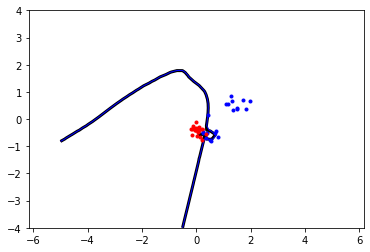

Polynomial p = 7


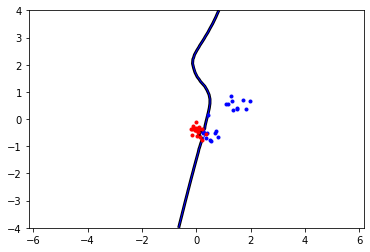

Polynomial p = 8


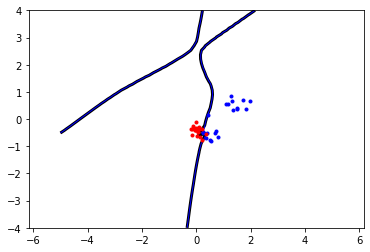

Polynomial p = 9


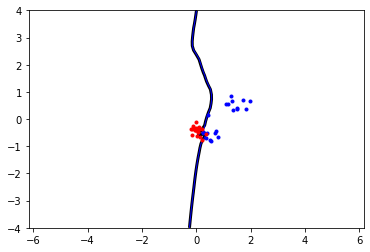

In [16]:
def indicator(x, y, lin=True):
    ind = 0
    for i in range(0, len(alpha)):
        if lin:
            ind += alpha[i] * targets[i] * linear_kernel((x,y), inputs[i])
        else:
            ind += alpha[i] * targets[i] * polynomial_kernel((x, y), inputs[i], POL)
    ind = ind - b
    return ind

def main(lin=True):
    B = [(0, None) for b in range(N)]
    XC = {'type':'eq', 'fun':zerofun}
    start = np.zeros(N)
    ret = minimize(objective , start, bounds=B, constraints=XC)
    alpha = ret['x']

    support_vectors=[]
    for i in range(0, len(alpha)):
        # low limit to help in later stage classification with a C that is lower than 1.e-4
        if alpha[i] > 1.e-15 and alpha[i]< C:
            support_vectors.append((alpha[i], (inputs[i])[0], (inputs[i])[1], targets[i]))

    # b calculated using formula 7 on pg. 3, and any support vector
    b_sum = 0
    sv = support_vectors[0]
    for i in range(0, len(alpha)):
        if lin:
            b_sum += alpha[i] * targets[i] * linear_kernel((sv[1],sv[2]), inputs[i])
        else:
            b_sum += alpha[i] * targets[i] * polynomial_kernel((sv[1],sv[2]), inputs[i], POL)

    b = b_sum - sv[3]
    
    # So we can use indicator in plotting further down
    return alpha, b

classA, classB, inputs, targets, N = generate_data(False)

for i in range(2,10):
    POL = i
    C = float("inf")
    P = np.array([np.array([targets[i] * targets[j]*polynomial_kernel(inputs[i], inputs[j], POL) for i in range(N)])
                 for j in range(N)])
    alpha, b = main(False)
    print('Polynomial p = '+ str(POL))
    plot_data_and_boundary(classA, classB, False)